# note:
loop through SMI parameters, with other indicator as default setting

testing stop loss / profit taking ratio

MACD seems to guarantee 60-70% accuracy




other condition (pending): ATR threshold, Bollinger_width threshold, RSI level, MACD level, SMI level 

# find best other conditions needed for signal function accuracy and profit

In [1]:
import os
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import time
import fredapi as fa
import pandas_ta as ta

from datetime import datetime

# 1.load minute data，standardize columns, date&time
directory = "C:/Users/chenl/market data export/MINUTE/"
SPY = pd.read_csv(directory + "QQQ.csv", parse_dates=["date"])
SPY['time'] = SPY['date'].dt.time
SPY['date'] = pd.to_datetime(SPY['date'].dt.date)
# Set the multi-level index using the date and time columns
SPY['time'] = SPY['time'].astype(str).str.zfill(8)
SPY.set_index(['date', 'time'], inplace=True)

# Filter 9:30-16:00
SPY = SPY.loc[(SPY.index.get_level_values('time') >= '09:00:00') & 
              (SPY.index.get_level_values('time') <= '16:00:00')&
              (SPY.index.get_level_values('date') >= pd.to_datetime('2024-04-01'))&
              (SPY.index.get_level_values('date') <= pd.to_datetime('2024-09-13'))
              ]
# load daily data, daily file
directory_day = "C:/Users/chenl/market data export/"
day_data = pd.read_csv(directory_day + "QQQ.csv")
day_data.rename(columns={"Unnamed: 0":"date","Close":"Daily_close"},inplace=True)
day_data["date"]=pd.to_datetime(day_data["date"])
# day_data.set_index(['date'], inplace=True)
# day_data


daily level indicators and merge into minute data

In [2]:
SPY.reset_index(inplace=True) # temparaly reset index
# Step 1: Calculate daily close prices for the entire dataset (not by group)
# Step 2: Calculate the 5-day, 20-day, and 50-day moving averages based on the daily close prices
day_data['5_day_MA'] = day_data['Daily_close'].rolling(window=5).mean()
day_data['20_day_MA'] =day_data['Daily_close'].rolling(window=20).mean()
day_data['50_day_MA'] = day_data['Daily_close'].rolling(window=50).mean()

# MACD: 
macd = ta.macd(day_data['Daily_close'], fast=12, slow=26, signal=9)
day_data['daily_MACD'] = macd['MACD_12_26_9'] # fast line
# daily_close_df['MACD_hist'] = macd['MACDh_12_26_9']
day_data['daily_MACD_signal'] = macd['MACDs_12_26_9'] # slow line

SPY=pd.merge(SPY,day_data[['date',"Daily_close",'5_day_MA', '20_day_MA', '50_day_MA','daily_MACD','daily_MACD_signal']],how="right",on="date")

SPY.set_index(['date', 'time'], inplace=True)

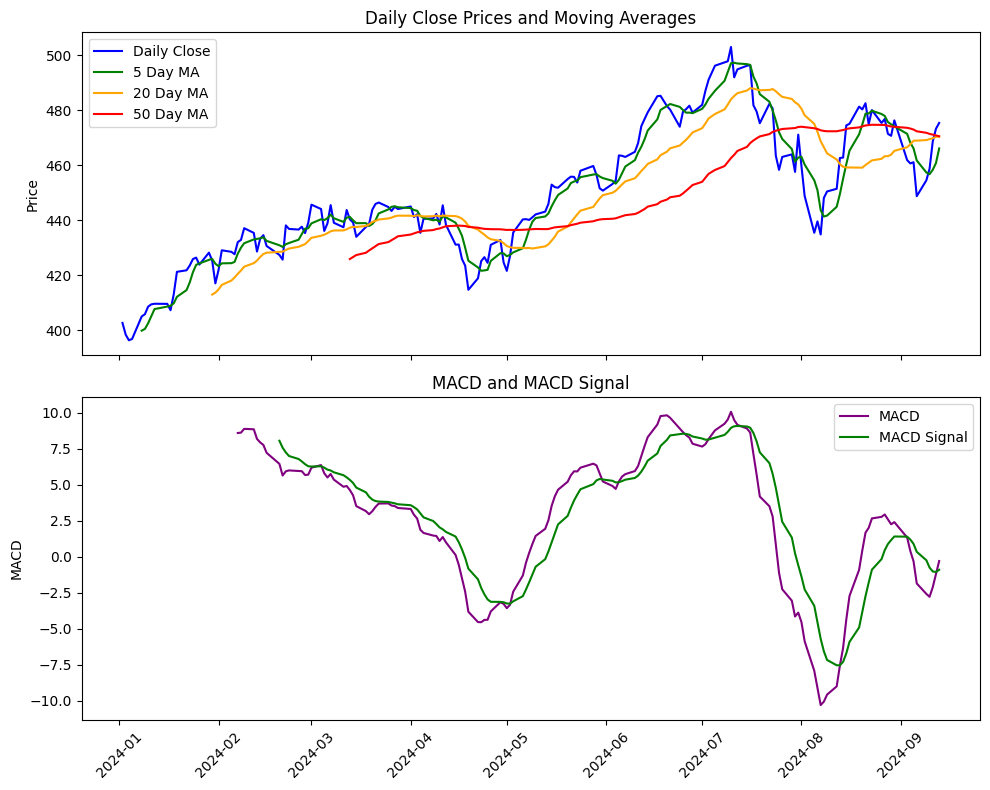

In [3]:
day_data.head(50)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot daily close and moving averages on the first axis
ax1.plot(day_data['date'], day_data['Daily_close'], label='Daily Close', color='blue')
ax1.plot(day_data['date'],day_data['5_day_MA'], label='5 Day MA', color='green')
ax1.plot(day_data['date'], day_data['20_day_MA'], label='20 Day MA', color='orange')
ax1.plot(day_data['date'], day_data['50_day_MA'], label='50 Day MA', color='red')

# Labels and title for the first plot
ax1.set_ylabel('Price')
ax1.set_title('Daily Close Prices and Moving Averages')
ax1.legend()

# Plot MACD and MACD Signal on the second axis
ax2.plot(day_data['date'], day_data['daily_MACD'], label='MACD', color='purple')
ax2.plot(day_data['date'], day_data['daily_MACD_signal'], label='MACD Signal', color='green')

# Labels and title for the second plot
ax2.set_ylabel('MACD')
ax2.set_title('MACD and MACD Signal')
ax2.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

missing minute data handling

minute level indicators

In [4]:
# 2. create intraday indicators value columns
#define ewm function for mannual SMI calcualtion 
def ema(series, period):
    return series.ewm(span=period, adjust=False).mean()
def intraday_indicators(group):
    #some days doesn't have minute data, functio calculation would return error, use try to skip the day
    try:
        # short term MA
        # group['SMA_3'] = ta.sma(group['close'], length=3)
        # group['SMA_5'] = ta.sma(group['close'], length=5)
        # group['SMA_7'] = ta.sma(group['close'], length=7)
        # group['SMA_10'] = ta.sma(group['close'], length=10)
        # #mid term MA
        # group['SMA_18'] = ta.sma(group['close'], length=18)
        # group['SMA_20'] = ta.sma(group['close'], length=20)
        # group['SMA_25'] = ta.sma(group['close'], length=25)
        # group['SMA_30'] = ta.sma(group['close'], length=30)
        # # long term MA
        # # group['SMA_120'] = ta.sma(group['close'], length=120) 
        # group['SMA_90'] = ta.sma(group['close'], length=90)
        # group['SMA_60'] = ta.sma(group['close'], length=60)

        # # ADX: Calculate the ADX using high, low, and close prices,
        # #+DI > -DI: The trend is upward. -DI > +DI: The trend is downward.
        # #0-25: Weak or no trend. 25-50: Strong trend. 50-75: Very strong trend. 75-100: Extremely strong trend.
        group['ADX'] = ta.adx(SPY['high'], SPY['low'], SPY['close'], length=20)['ADX_20']   

        # # RSI 
        # group['RSI_21'] = ta.rsi(group['close'], length=21)

        # MACD: 
        macd = ta.macd(group['close'], fast=12, slow=26, signal=9)
        group['MACD'] = macd['MACD_12_26_9'] # fast line
        # group['MACD_hist'] = macd['MACDh_12_26_9']
        group['MACD_signal'] = macd['MACDs_12_26_9'] # slow line

        # #bollinger: create new dp with multiple columne then merge back
        bollinger = ta.bbands(group['close'], length=20, std=2)
        # group['Bollinger_upper'] = bollinger['BBU_20_2.0']
        # group['Bollinger_middle'] = bollinger['BBM_20_2.0']
        # group['Bollinger_lower'] = bollinger['BBL_20_2.0']
        group['Bollinger_width'] = (bollinger['BBU_20_2.0']-bollinger['BBL_20_2.0'])/bollinger['BBM_20_2.0']
        
        # # ATR - volatility measure, max up and down range, used for gain collection stop loss 
        group["ATR"]=ta.atr(group.high, group.low, group.close, length =14)
        # group["rolling_std_14"]=group["close"].pct_change().rolling(window=14).std()*group["close"]
        
        # SMI: difference between the current closing and the median high/low price range over a specified period the k period. 
        # This difference is then divided by the absolute value of the high/low range and multiplied by 100
        # SMI line crosses above the signal line, considered bullish, when the SMI line crosses below the signal line, a bearish signal
        # relativeRange = close - (highestHigh + lowestLow) / 2; double exponential moving average: ds = EMA(EMA(relativeRange, D);
        # dhl = EMA(EMA((highestHigh - lowestLow), D; smi = 200 * (ds / dhl); signal = EMA(smi, EMA period)

        for k_period in k_period_list:
            for ema_period in ema_period_list:
                for d_period in d_period_list:
                    # following column are temperate, no need to save in DF
                    column_suffix = f"{k_period}_{d_period}_{ema_period}"  # Create a unique suffix for each combination
                    # highest high and lowest low within the K period
                    highest_high = group["high"].rolling(window=k_period).max()
                    lowest_low = group["low"].rolling(window=k_period).min()
                    #relative range & double exponential MA
                    relative_range = group["close"] - (highest_high + lowest_low) / 2
                    ds = ema(ema(relative_range, d_period), d_period)
                    dhl = ema(ema(highest_high - lowest_low, d_period), d_period)    

                    # dhl = dhl.replace(0, np.nan)  # Replace 0s with NaN to avoid extreme values            

                    # SMI and SMI_signal and store them as SMI_k_d_ema column name
                    group[f'SMI_{column_suffix}'] = 200 * (ds / dhl)
                    group[f'SMI_signal_{column_suffix}'] = ema(group[f'SMI_{column_suffix}'], ema_period)   

        #daily volatility
        group["minute_returns"]=group["close"].pct_change()
        group["daily_volatility"]=group.groupby("date")["minute_returns"].transform("std")

        # warning: the ta package SMI line and signal line calculation is wrong!! don't use it!
        # Stochastic Momentum Index: SMI Line: The main line; Signal line (D); Oscillator (K): smoothed version of the SMI
        # smi = ta.smi(high=group['high'], low=group['low'], close=group['close'], fast_k=5, slow_k=3, slow_d=3)
        # group['SMI'] = smi['SMI_5_20_5']*100 #main line
        # group['SMI_signal'] = smi['SMIs_5_20_5']*100#Signal line (D)
        
        #target change
        group['pct_change_2min'] = group['close'].pct_change(periods=-2) * 100
        group['pct_change_5min'] = group['close'].pct_change(periods=-5) * 100
        # group['pct_change_7min'] = group['close'].pct_change(periods=-7) * 100
        group['pct_change_10min'] = group['close'].pct_change(periods=-10) * 100
        group['pct_change_20min'] = group['close'].pct_change(periods=-20) * 100
        group['pct_change_30min'] = group['close'].pct_change(periods=-30) * 100
        group['pct_change_45min'] = group['close'].pct_change(periods=-45) * 100
        group['pct_change_60min'] = group['close'].pct_change(periods=-60) * 100
        #target direction
        group['direction_2min'] = np.sign(group['close'].shift(-2) - group['close'])
        group['direction_5min'] = np.sign(group['close'].shift(-5) - group['close'])
        # group['direction_7min'] = np.sign(group['close'].shift(-7) - group['close'])
        group['direction_10min'] = np.sign(group['close'].shift(-10) - group['close'])
        group['direction_20min'] = np.sign(group['close'].shift(-20) - group['close'])
        group['direction_30min'] = np.sign(group['close'].shift(-30) - group['close']) 
        group['direction_45min'] = np.sign(group['close'].shift(-45) - group['close']) 
        group['direction_60min'] = np.sign(group['close'].shift(-60) - group['close']) 
        return group
    except Exception as e:
        return group

# 3. generate signals columns for each strategy
def generate_signals(df, k_period, d_period, ema_period):
    signal_column= f"SMI_{k_period}_{d_period}_{ema_period}_signal" #created unique smi_k_d_ema_singal column
    df[signal_column]=0
    for date, group in df.groupby('date'):
         for i in range(1, len(group)):
            smi_column=f'SMI_{k_period}_{d_period}_{ema_period}' #identify column name created earlier
            smi_signal_column=f'SMI_signal_{k_period}_{d_period}_{ema_period}'
        
            if group.iloc[i][[
                # 'RSI_21', 'MACD', 'MACD_signal', 'Bollinger_width',"ATR", 
                              smi_column, smi_signal_column
                              ]].isna().any():
                continue
            # Generate signal when smi cross signal, or rise above -40, dailay MACD bull as reversal climbing phase, 
            if (group.iloc[i][smi_column] > group.iloc[i][smi_signal_column] and group.iloc[i-1][smi_column] <= group.iloc[i-1][smi_signal_column] and 
                group.iloc[i][smi_column]<=30) and (group.iloc[i]['MACD']>=-0.2 and group.iloc[i]['MACD']<=0.2 and group.iloc[i]['MACD']>group.iloc[i]['MACD_signal']
                                                    ) and (group.iloc[i]['5_day_MA']>group.iloc[i]['20_day_MA'] or  # day level condition check
                                                           group.iloc[i]['daily_MACD']>group.iloc[i]['daily_MACD_signal']):

                # add other condition below
                # group.iloc[i]['ADX']>25 
                # group.iloc[i]['RSI_21']>10 and group.iloc[i]['RSI_21']<60 
                df.at[group.index[i], signal_column] = 1
            # Generate reverse signal, smi over 65, cross down, or macd start turning lower
            elif group.iloc[i][smi_column] >=80 or (group.iloc[i][smi_column] < group.iloc[i][smi_signal_column] and 
                                                   group.iloc[i-1][smi_column] >= group.iloc[i-1][smi_signal_column] and 
                                                   group.iloc[i][smi_column] >50):
                # (group.iloc[i][smi_column] < group.iloc[i][smi_signal_column] and group.iloc[i-1][smi_column] >= group.iloc[i-1][smi_signal_column]) 
                df.at[group.index[i], signal_column] = -1
    return df

# 4. create logs for MA cross strategy,loop each row
def simulate_trading(df, signal_column,atr_stop_loss_multiplier, atr_take_profit_multiplier):
    balance = 100000
    position = 0
    entry_price = None
    portfolio = []

    # Group the DataFrame by 'date' to simulate day trading, loop each row, enter new trade and closing postion
    for date, group in df.groupby('date'):
        stop_loss_level = None #reset each day
        take_profit_level = None #reset each day
        
        for index, row in group.iterrows(): #loop per minute in each day
            date_str = str(index[0].date())  # Get the date from the index
            time = index[1]  # Get the time from the index
            
            # Open a position if the signal is 1 and no position is currently open
            if row[signal_column] == 1 and position == 0:
                position += 100
                balance -= 100 * row['close']
                entry_price=row["close"]
                # 1 set the ATR-based stop loss and take profit levels for current trade
                # stop_loss_level = entry_price - atr_stop_loss_multiplier * row['ATR']
                # take_profit_level = entry_price + atr_take_profit_multiplier * row['ATR']
                
                # 2 set abs % chagne as stop loss and take profit levels for current trade
                stop_loss_level = entry_price - atr_stop_loss_multiplier * entry_price
                take_profit_level = entry_price + atr_take_profit_multiplier * entry_price
                
                log.append({'action': 'buy', 'shares': 100, 'price': row['close'], "return":None,'balance': balance,
                            'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
            
            # negative signal: Close the position if the signal is -1 and a position is currently open
            elif row[signal_column] == -1 and position > 0:
                balance += 100 * row['close']
                position -= 100
                price_change=(row["close"]-entry_price)/entry_price
                log.append({'action': 'sell', 'shares': 100, 'price': row['close'],"return":f"{price_change}", 'balance': balance,
                            'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
                entry_price = None # Reset entry price
                
            #stop loss and profit taking conditions, select one
            # #1 entry price diff % method 
            # if position>0:
            #     price_change=(row["close"]-entry_price)/entry_price
            #     # stop loss
            #     if price_change<=stop_loss:
            #         balance+=100*row["close"]
            #         position-=100
            #         log.append({'action': 'sell to stop', 'shares': 100, 'price': row['close'], "return":f"{price_change}%", 'balance': balance, 
            #                     'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
            #         entry_price=None # Reset entry price
            #         stop_loss_level = None # Reset
            #         take_profit_level = None # Reset 
            #     # take profit
            #     elif price_change>=take_profit:
            #         balance += 100 * row['close']
            #         position -= 100
            #         log.append({'action': 'sell to profit', 'shares': 100, 'price': row['close'],"return":f"{price_change}%", 'balance': balance,
            #                     'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
            #         entry_price = None  # Reset entry price
            #         stop_loss_level = None # Reset
            #         take_profit_level = None # Reset  
            
            #2 ATR: x of ATR below or above entry price
            if position>0:
                price_change=(row["close"]-entry_price)/entry_price
                # stop loss
                if row["close"]<=stop_loss_level:
                    balance+=100*row["close"]
                    position-=100
                    log.append({'action': 'sell to stop', 'shares': 100, 'price': row['close'], "return":f"{price_change}", 'balance': balance, 
                                'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
                    entry_price=None # Reset entry price
                    stop_loss_level = None # Reset
                    take_profit_level = None # Reset                    
                # take profit
                elif row["close"]>=take_profit_level:
                    balance += 100 * row['close']
                    position -= 100
                    log.append({'action': 'sell to profit', 'shares': 100, 'price': row['close'],"return":f"{price_change}", 'balance': balance,
                                'portfolio_value': balance + position * row['close'], 'date': date_str, 'time': time})
                    entry_price = None  # Reset entry price
                    stop_loss_level = None # Reset
                    take_profit_level = None # Reset
                
            # record the current portfolio value for each row
            portfolio.append(balance + position * row['close'])

        # close: time base; At the EOD, in each date loop, close any remaining open positions
        if position > 0:
            balance += 100 * group.iloc[-1]['close']  # Use the last row's close price to close the position
            price_change=(group.iloc[-1]['close']-entry_price)/entry_price
            log.append({'action': 'sell at EOD', 'shares': 100, 'price': group.iloc[-1]['close'],"return":f"{price_change}", 'balance': balance, 
                        'portfolio_value': balance, 'date': date_str, 'time': group.index[-1][1]})
            position -= 100  # Reset position to 0, sell 100
            entry_price = None 
    
        # Correct the final portfolio value for the last row of the day
        portfolio[-1] = balance  # Ensure the last entry for the day is correct
    #signal column used for unique parameter portfolio
    # df['portfolio_' + signal_column] = portfolio
    return pd.Series(portfolio, index=df.index, name=f'portfolio_{signal_column}_{atr_stop_loss_multiplier}_{atr_take_profit_multiplier}_ATR')


# Reset the index, group by the 'date' column, apply the function, and set the multi-level index again, create features
#short term 
k_period_list = [50,40,30,24,18]
d_period_list = [3, 5,9,12,15]
ema_period_list = [3, 5,9,12,15]
#longer term
# k_period_list = [150,120,90]
# d_period_list = [6,9,15,20,30]
# ema_period_list = [6,9,15,20,30]

# longer term fast line
# k_period_list = [180,150,120,90]
# d_period_list = [30,40,50]
# ema_period_list = [30,40,50]

#create indicators
SPY.reset_index(inplace=True)
SPY = SPY.groupby('date').apply(intraday_indicators)
SPY.set_index(['date', 'time'], inplace=True) 

# Define ATR multiplier combinations
# atr_multiplier_stop_loss_list = [1, 1.5]
# atr_multiplier_take_profit_list = [3.0,2.0,1.5]
# use abs % change as multiplier * entry price
atr_multiplier_stop_loss_list = [0.01]
atr_multiplier_take_profit_list = [0.015]



C:\Users\chenl\AppData\Local\Temp\ipykernel_15760\2168117182.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group[f'SMI_signal_{column_suffix}'] = ema(group[f'SMI_{column_suffix}'], ema_period)
C:\Users\chenl\AppData\Local\Temp\ipykernel_15760\2168117182.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group[f'SMI_{column_suffix}'] = 200 * (ds / dhl)
C:\Users\chenl\AppData\Local\Temp\ipykernel_15760\2168117182.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

loop search & simulating trades

In [5]:
# Initialize a list to hold all the portfolio Series
portfolio_columns = []

# Loop through each combination of MA and ATR multipliers
logs = []
for k_period in k_period_list:
    for ema_period in ema_period_list:
        for d_period in d_period_list:
            SPY=generate_signals (SPY,k_period, d_period, ema_period) #looped signal columns created in indicator function and generated signal
            signal_column=f"SMI_{k_period}_{d_period}_{ema_period}_signal" 
            # loop for trades
            for stop_loss in atr_multiplier_stop_loss_list:
                for take_profit in atr_multiplier_take_profit_list:
                    log=[]
                    log_name=f"SMI_{k_period}_{d_period}_{ema_period}_ATR_{stop_loss}_{take_profit}"
                    # SPY = simulate_trading(SPY, signal_column, log, stop_loss, take_profit)
                    portfolio_series = simulate_trading(SPY, signal_column, stop_loss, take_profit)
                    portfolio_columns.append(portfolio_series)                    
                    logs.append((log_name, log))

# Concatenate all the portfolio Series into the SPY DataFrame at once
SPY = pd.concat([SPY] + portfolio_columns, axis=1)

C:\Users\chenl\AppData\Local\Temp\ipykernel_15760\2168117182.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[signal_column]=0
C:\Users\chenl\AppData\Local\Temp\ipykernel_15760\2168117182.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[signal_column]=0
C:\Users\chenl\AppData\Local\Temp\ipykernel_15760\2168117182.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [6]:
# Extract all log names from logs_ma
# log_names = [log_name for log_name, _ in logs]

# log_names

In [7]:
# SPY["ATR"].describe()
# SPY['Bollinger_width'].describe()
# SPY.columns



# trade results

In [8]:
# Initialize a list to hold the summary for each strategy
strategy_summary = []

# Iterate over each log/strategy in logs_ma
for log_name, log in logs:
    # Convert log to a DataFrame
    log_df = pd.DataFrame(log)
    
    # Filter for completed trades (buy followed by a sell)
    trades = log_df[log_df['action'].isin(['buy', 'sell', 'sell to stop', 'sell to profit', 'sell at EOD'])]
    
    # Calculate total number of round trades (each round trade has a buy and a sell)
    total_round_trades = len(trades) // 2
    
    # Initialize variables for calculations
    wins = 0
    hold_times=[]
    total_returns = []
    final_portfolio_value = log_df.iloc[-1]['portfolio_value'] if not log_df.empty else 0
    
    # Calculate winning trades and returns for each round trade
    for i in range(0, len(trades) - 1, 2):  # Step by 2 to get pairs of buy/sell trades
        buy_price = trades.iloc[i]['price']
        sell_price = trades.iloc[i + 1]['price']
        trade_return = (sell_price - buy_price) / buy_price
        # Calculate the hold time and store it in seconds
        hold_time = (pd.to_datetime(trades.iloc[i+1]['time']) - pd.to_datetime(trades.iloc[i]['time'])).total_seconds()/60
        hold_times.append(hold_time)
        # Store the return
        total_returns.append(trade_return)
      
        # Check if the trade was a winning trade
        if trade_return > 0:
            wins += 1

    # Calculate winning rate
    winning_rate = wins / total_round_trades if total_round_trades > 0 else 0

    # calculate average hold time
    average_hold_time=np.mean(hold_times) if hold_times else 0

    # Calculate summary statistics for the return distribution
    # return_distribution_summary = pd.Series(total_returns).describe()

    # Store the summary for this strategy
    strategy_summary.append({
        'Strategy': log_name,
        'Total Round Trades': total_round_trades,
        'Winning Rate': winning_rate,
        'Total value': final_portfolio_value,
        'Average Hold Time (minute)': average_hold_time  # Add average hold time
        # 'Return Distribution': return_distribution_summary
    })

# Convert the summary to a DataFrame for easier viewing
summary_df = pd.DataFrame(strategy_summary)

In [22]:
# summary_df.sort_values(by="Winning Rate").tail(20)
summary_df.sort_values(by="Total value").tail(20)
# len(summary_df)

Strategy  Total Round Trades  Winning Rate  \
60     SMI_30_3_9_ATR_0.01_0.015                 177      0.677966   
76     SMI_24_5_3_ATR_0.01_0.015                 169      0.644970   
112    SMI_18_9_9_ATR_0.01_0.015                 195      0.656410   
123  SMI_18_12_15_ATR_0.01_0.015                 152      0.611842   
52     SMI_30_9_3_ATR_0.01_0.015                 209      0.602871   
31     SMI_40_5_5_ATR_0.01_0.015                 205      0.658537   
87     SMI_24_9_9_ATR_0.01_0.015                 195      0.646154   
8     SMI_50_12_5_ATR_0.01_0.015                 159      0.578616   
92    SMI_24_9_12_ATR_0.01_0.015                 186      0.634409   
12     SMI_50_9_9_ATR_0.01_0.015                 164      0.609756   
17    SMI_50_9_12_ATR_0.01_0.015                 157      0.630573   
66    SMI_30_5_12_ATR_0.01_0.015                 202      0.648515   
105    SMI_18_3_5_ATR_0.01_0.015                 148      0.709459   
65    SMI_30_3_12_ATR_0.01_0.015                 183      0.683060   
57     SMI_30_9_5_ATR_0.01_0.015                 200      0.650000   
51     SMI_30_5_3_ATR_0.01_0.015                 182      0.675824   
100    SMI_18_3_3_ATR_0.01_0.015                 151      0.695364   
62     SMI_30_9_9_ATR_0.01_0.015                 192      0.656250   
71    SMI_30_5_15_ATR_0.01_0.015                 193      0.689119   
55     SMI_30_3_5_ATR_0.01_0.015                 160      0.725000   

     Total value  Average Hold Time (minute)  
60     100518.72                   38.576271  
76     100538.40                   33.633136  
112    100541.65                   62.158974  
123    100571.33                   90.414474  
52     100588.32                   49.952153  
31     100656.19                   43.034146  
87     100678.81                   61.041026  
8      100749.19                   60.817610  
92     100876.29                   64.962366  
12     100911.90                   57.896341  
17     100994.60                   60.535032  
66     101023.71                   51.193069  
105    101050.82                   28.033784  
65     101079.61                   43.060109  
57     101127.42                   54.015000  
51     101183.47                   35.478022  
100    101202.70                   25.496689  
62     101220.51                   57.692708  
71     101323.00                   53.098446  
55     101510.78                   33.575000

In [23]:
# result export
summary_df.to_csv('C:/Users/chenl/trading strategy/forloop serach/summary.csv')

# market data export
# SPY.to_csv('C:/Users/chenl/trading strategy/forloop serach/QQQ_processed.csv')

# print(os.getcwd())

In [16]:
desired_log_names = [
    'SMI_30_3_5_ATR_0.01_0.015',
]
filter_log=[log for log_name,log in logs if log_name in desired_log_names]
# pd.DataFrame(filter_log)
filter_log=filter_log[0]
# Convert the extracted log data to a DataFrame
df_log = pd.DataFrame(filter_log)

# Display the DataFrame

print(df_log["action"].value_counts())
df_log.head(20)
# df_log[df_log["action"]=="sell to stop"]
# df_log[df_log["action"]=="sell"]

action
buy             160
sell            143
sell at EOD      15
sell to stop      2
Name: count, dtype: int64


action  shares    price                   return   balance  \
0           buy     100  433.660                     None   56634.0   
1          sell     100  434.290    0.0014527510030899677  100063.0   
2           buy     100  435.180                     None   56545.0   
3          sell     100  435.090  -0.00020681097476913423  100054.0   
4           buy     100  435.890                     None   56465.0   
5          sell     100  435.709    -0.000415242377664051  100035.9   
6           buy     100  435.770                     None   56458.9   
7   sell at EOD     100  435.730   -9.179154140937564e-05  100031.9   
8           buy     100  437.950                     None   56236.9   
9          sell     100  438.070    0.0002740038817216681  100043.9   
10          buy     100  439.080                     None   56135.9   
11         sell     100  439.220    0.0003188485014121418  100057.9   
12          buy     100  440.470                     None   56010.9   
13         sell     100  441.235    0.0017367811655731066  100134.4   
14          buy     100  441.480                     None   55986.4   
15         sell     100  441.740     0.000588928150765586  100160.4   
16          buy     100  440.600                     None   56100.4   
17         sell     100  440.150   -0.0010213345438040069  100115.4   
18          buy     100  439.960                     None   56119.4   
19         sell     100  439.790   -0.0003863987635238637  100098.4   

    portfolio_value        date      time  
0          100000.0  2024-05-03  11:16:00  
1          100063.0  2024-05-03  11:30:00  
2          100063.0  2024-05-03  13:48:00  
3          100054.0  2024-05-03  13:59:00  
4          100054.0  2024-05-03  15:04:00  
5          100035.9  2024-05-03  15:12:00  
6          100035.9  2024-05-03  15:52:00  
7          100031.9  2024-05-03  16:00:00  
8          100031.9  2024-05-06  10:37:00  
9          100043.9  2024-05-06  11:37:00  
10         100043.9  2024-05-06  14:54:00  
11         100057.9  2024-05-06  15:41:00  
12         100057.9  2024-05-07  10:35:00  
13         100134.4  2024-05-07  10:54:00  
14         100134.4  2024-05-07  13:07:00  
15         100160.4  2024-05-07  13:29:00  
16         100160.4  2024-05-07  14:11:00  
17         100115.4  2024-05-07  15:02:00  
18         100115.4  2024-05-08  11:58:00  
19         100098.4  2024-05-08  13:53:00

In [17]:
df_log_filtered = df_log[df_log['return'].notna()]

df_log_filtered['return'] = df_log_filtered['return'].astype(float)

# Get the distribution summary
distribution_summary = df_log_filtered['return'].describe()

# Print the summary statistics
print(distribution_summary)

count    160.000000
mean       0.000209
std        0.002060
min       -0.010124
25%       -0.000125
50%        0.000542
75%        0.001190
max        0.006413
Name: return, dtype: float64


C:\Users\chenl\AppData\Local\Temp\ipykernel_15760\2256646117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_log_filtered['return'] = df_log_filtered['return'].astype(float)


In [18]:
import matplotlib.pyplot as plt

# Convert 'date' and 'time' columns to a single datetime column for plotting
df_log['datetime'] = pd.to_datetime(df_log['date'] + ' ' + df_log['time'])

# Set 'datetime' as the index for better plotting
df_log.set_index('datetime', inplace=True)

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(df_log.index, df_log['portfolio_value'], label='Portfolio Value', color='blue', marker='o')

# Highlight 'buy' and 'sell' actions on the graph
buy_signals = df_log[df_log['action'] == 'buy']
sell_signals = df_log[df_log['action'].str.contains('sell')]

# Plot buy signals
plt.scatter(buy_signals.index, buy_signals['portfolio_value'], label='Buy Signal', color='green', marker='^', s=100)

# Plot sell signals
plt.scatter(sell_signals.index, sell_signals['portfolio_value'], label='Sell Signal', color='red', marker='v', s=100)

# Add labels and title
plt.title('Portfolio Value Over Time with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# distribution of stock movement after signal triggered

In [14]:
# Filter rows where 'signal_macd' equals 1
df_filtered = SPY[SPY['SMI_30_3_3_signal'] == 1]

# Plot the distributions
plt.figure(figsize=(16, 12))

plt.subplot(3, 3, 4)
plt.hist(df_filtered['pct_change_2min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 2min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 1)
plt.hist(df_filtered['pct_change_5min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 5min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 2)
plt.hist(df_filtered['pct_change_10min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 10min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 3)
plt.hist(df_filtered['pct_change_20min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 20min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 5)
plt.hist(df_filtered['pct_change_30min'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of 30min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 6)
plt.hist(df_filtered['pct_change_45min'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of 45min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 7)
plt.hist(df_filtered['pct_change_60min'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of 60min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

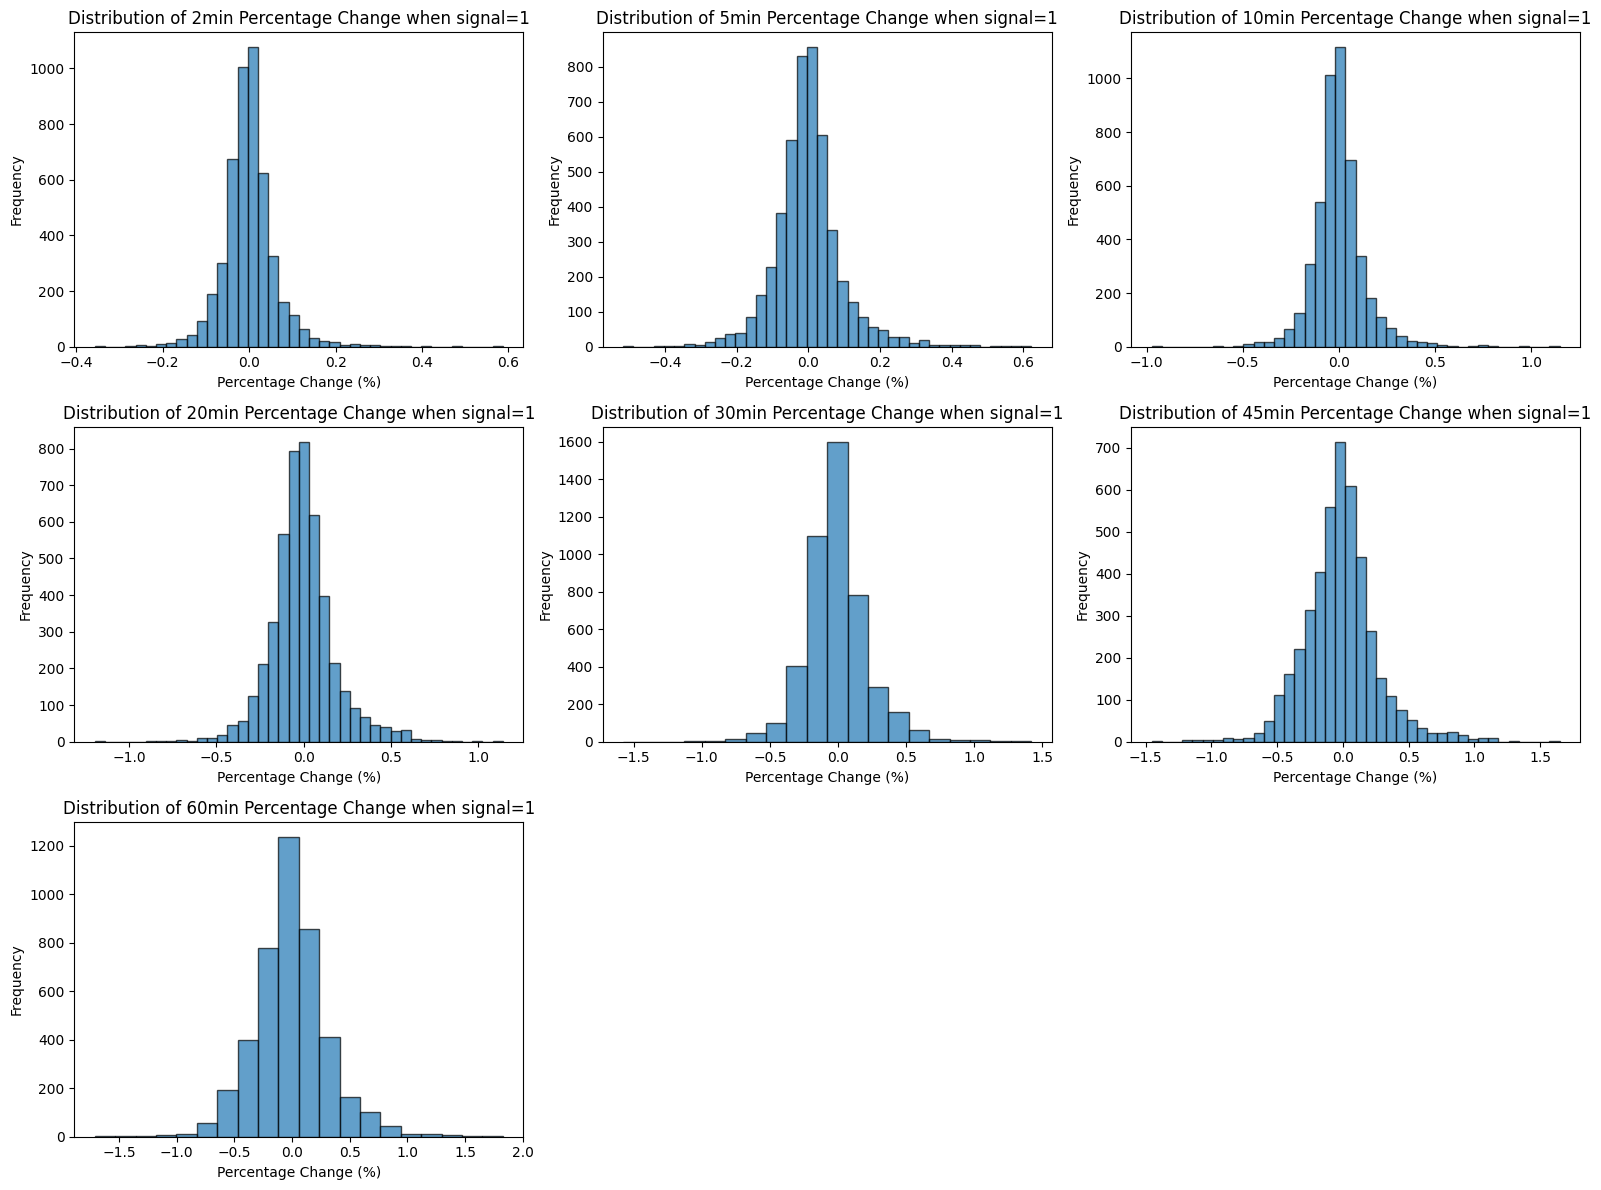

In [19]:
# Filter rows where 'signal_macd' equals 1
df_filtered = SPY[SPY['SMI_30_3_3_signal'] == -1]

# Plot the distributions
plt.figure(figsize=(16, 12))

plt.subplot(3, 3, 1)
plt.hist(df_filtered['pct_change_2min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 2min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 2)
plt.hist(df_filtered['pct_change_5min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 5min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 3)
plt.hist(df_filtered['pct_change_10min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 10min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 4)
plt.hist(df_filtered['pct_change_20min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 20min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 5)
plt.hist(df_filtered['pct_change_30min'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of 30min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 6)
plt.hist(df_filtered['pct_change_45min'].dropna(), bins=40, edgecolor='k', alpha=0.7)
plt.title('Distribution of 45min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.subplot(3, 3, 7)
plt.hist(df_filtered['pct_change_60min'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of 60min Percentage Change when signal=1')
plt.xlabel('Percentage Change (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [135]:
# Calculate descriptive BB width
# mean_width = SPY['Bollinger_width'].mean()
# median_width =  SPY['Bollinger_width'].median()
# std_width =  SPY['Bollinger_width'].std()
# min_width =  SPY['Bollinger_width'].min()
# max_width =  SPY['Bollinger_width'].max()
# quantiles =  SPY['Bollinger_width'].quantile([0.25, 0.5, 0.75])

# print("Descriptive Statistics for Bollinger Band Width:")
# print(f"Mean: {mean_width}")
# print(f"Median: {median_width}")
# print(f"Standard Deviation: {std_width}")
# print(f"Minimum: {min_width}")
# print(f"Maximum: {max_width}")
# print(f"25th, 50th (median), 75th Percentile:\n{quantiles}")

# # Plot the distribution using a histogram
# plt.figure(figsize=(10, 6))
# plt.hist( SPY['Bollinger_width'].dropna(), bins=30, edgecolor='k', alpha=0.7)
# plt.title('Distribution of Bollinger Band Width')
# plt.xlabel('Bollinger Band Width')
# plt.ylabel('Frequency')
# plt.show()

# # Plot the distribution using a box plot
# plt.figure(figsize=(8, 6))
# plt.boxplot( SPY['Bollinger_width'].dropna(), vert=False)
# plt.title('Box Plot of Bollinger Band Width')
# plt.xlabel('Bollinger Band Width')
# plt.show()

checking if there are distinct diff betwwen direction movemnet group comparison

In [17]:
# ['direction_2min']
# ['direction_10min']
# ['direction_5min'] 
# ['direction_20min'] 
# ['direction_30min'] 
# ['direction_45min'] 
# ['direction_60min'] 

# SMI_30_3_12_ATR_0.01_0.015	
# SMI_30_9_5_ATR_0.01_0.015	
# SMI_24_9_12_ATR_0.01_0.015	
# SMI_30_3_5_ATR_0.01_0.015	
# SMI_30_3_3_ATR_0.01_0.015	
# SMI_24_9_9_ATR_0.01_0.015	

Index(['open', 'high', 'low', 'close', 'volume', 'Daily_close', '5_day_MA',
       '20_day_MA', '50_day_MA', 'daily_MACD',
       ...
       'portfolio_SMI_18_3_12_signal_0.01_0.015_ATR',
       'portfolio_SMI_18_5_12_signal_0.01_0.015_ATR',
       'portfolio_SMI_18_9_12_signal_0.01_0.015_ATR',
       'portfolio_SMI_18_12_12_signal_0.01_0.015_ATR',
       'portfolio_SMI_18_15_12_signal_0.01_0.015_ATR',
       'portfolio_SMI_18_3_15_signal_0.01_0.015_ATR',
       'portfolio_SMI_18_5_15_signal_0.01_0.015_ATR',
       'portfolio_SMI_18_9_15_signal_0.01_0.015_ATR',
       'portfolio_SMI_18_12_15_signal_0.01_0.015_ATR',
       'portfolio_SMI_18_15_15_signal_0.01_0.015_ATR'],
      dtype='object', length=532)

In [19]:
# getting SMI list
SMI_list=[]
# SMI_signal_list=[]
for k_period in k_period_list:
    for ema_period in ema_period_list:
        for d_period in d_period_list:
            column_suffix = f"{k_period}_{d_period}_{ema_period}"  # Create a unique suffix for each combination
            # SMI and SMI_signal and store them as SMI_k_d_ema column name
            SMI_list.append(f'SMI_{column_suffix}')
            # SMI_signal_list.append(f'SMI_signal_{column_suffix}')
SMI_list

['SMI_50_3_3',
 'SMI_50_5_3',
 'SMI_50_9_3',
 'SMI_50_12_3',
 'SMI_50_15_3',
 'SMI_50_3_5',
 'SMI_50_5_5',
 'SMI_50_9_5',
 'SMI_50_12_5',
 'SMI_50_15_5',
 'SMI_50_3_9',
 'SMI_50_5_9',
 'SMI_50_9_9',
 'SMI_50_12_9',
 'SMI_50_15_9',
 'SMI_50_3_12',
 'SMI_50_5_12',
 'SMI_50_9_12',
 'SMI_50_12_12',
 'SMI_50_15_12',
 'SMI_50_3_15',
 'SMI_50_5_15',
 'SMI_50_9_15',
 'SMI_50_12_15',
 'SMI_50_15_15',
 'SMI_40_3_3',
 'SMI_40_5_3',
 'SMI_40_9_3',
 'SMI_40_12_3',
 'SMI_40_15_3',
 'SMI_40_3_5',
 'SMI_40_5_5',
 'SMI_40_9_5',
 'SMI_40_12_5',
 'SMI_40_15_5',
 'SMI_40_3_9',
 'SMI_40_5_9',
 'SMI_40_9_9',
 'SMI_40_12_9',
 'SMI_40_15_9',
 'SMI_40_3_12',
 'SMI_40_5_12',
 'SMI_40_9_12',
 'SMI_40_12_12',
 'SMI_40_15_12',
 'SMI_40_3_15',
 'SMI_40_5_15',
 'SMI_40_9_15',
 'SMI_40_12_15',
 'SMI_40_15_15',
 'SMI_30_3_3',
 'SMI_30_5_3',
 'SMI_30_9_3',
 'SMI_30_12_3',
 'SMI_30_15_3',
 'SMI_30_3_5',
 'SMI_30_5_5',
 'SMI_30_9_5',
 'SMI_30_12_5',
 'SMI_30_15_5',
 'SMI_30_3_9',
 'SMI_30_5_9',
 'SMI_30_9_9',
 'SMI_30_12

SMI distribution seems to showing higher than 50% of direction indication
however, mostly skew to the up end, higher than 60

maybe be used to stop loss and collect profit

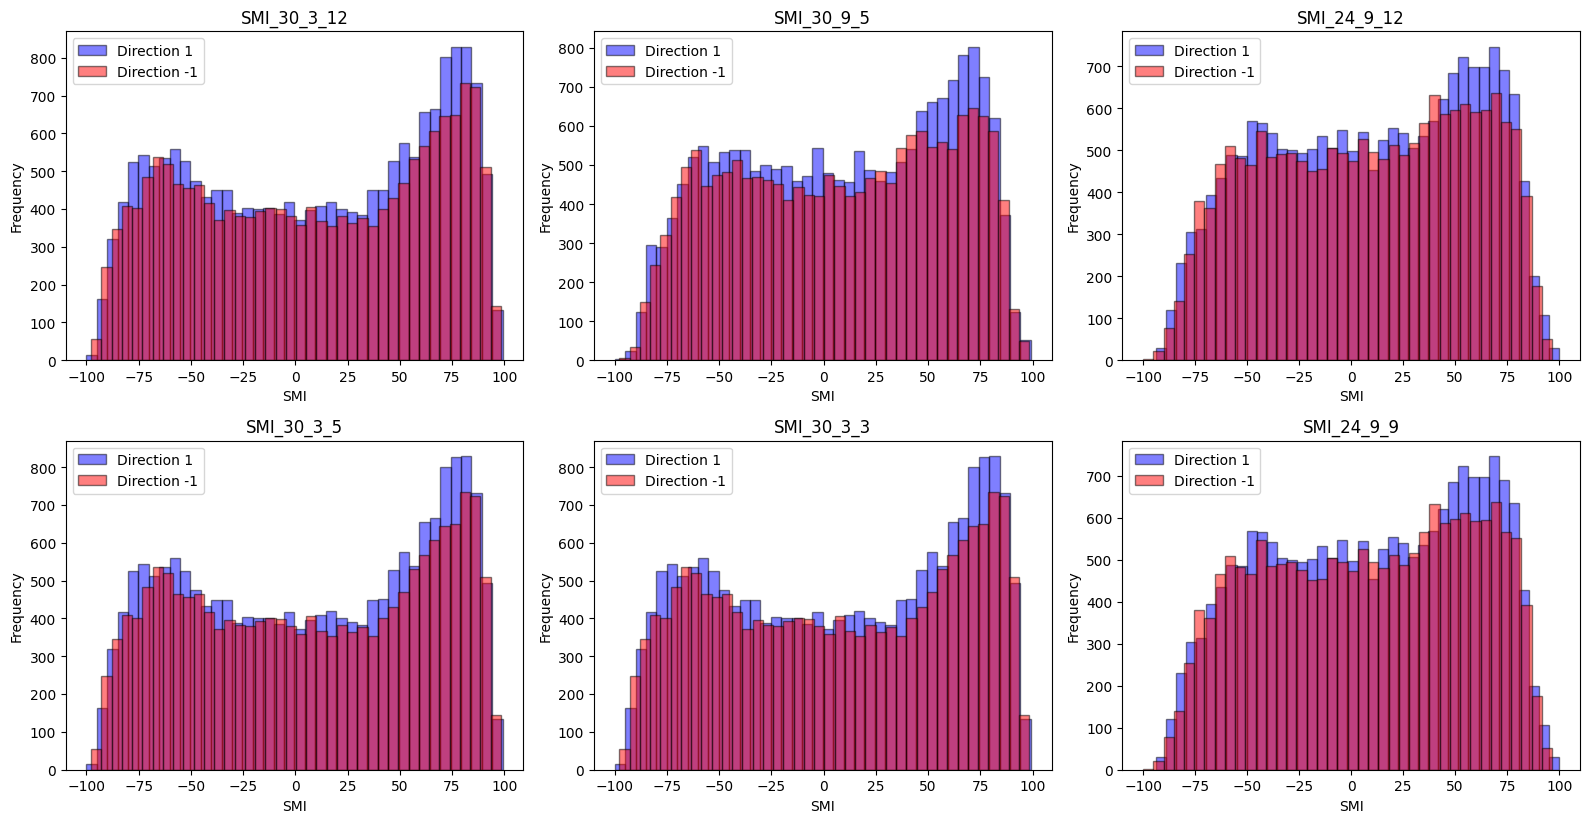

In [20]:
# pick few high profit SMI index combination for distrubtion analysis
df_filtered_up = SPY[SPY['direction_5min'] == 1]
df_filtered_down = SPY[SPY['direction_5min'] == -1]

# Plot the distributions for each SMI combination
plt.figure(figsize=(16, 12))

plt.subplot(3, 3, 1)
plt.hist(df_filtered_up['SMI_30_3_12'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction 1', color='blue')
plt.hist(df_filtered_down['SMI_30_3_12'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction -1', color='red')
plt.title("SMI_30_3_12")
plt.xlabel('SMI')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3, 3, 2)
plt.hist(df_filtered_up['SMI_30_9_5'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction 1', color='blue')
plt.hist(df_filtered_down['SMI_30_9_5'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction -1', color='red')
plt.title("SMI_30_9_5")
plt.xlabel('SMI')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3, 3, 3)
plt.hist(df_filtered_up['SMI_24_9_12'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction 1', color='blue')
plt.hist(df_filtered_down['SMI_24_9_12'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction -1', color='red')
plt.title("SMI_24_9_12")
plt.xlabel('SMI')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3, 3, 4)
plt.hist(df_filtered_up['SMI_30_3_5'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction 1', color='blue')
plt.hist(df_filtered_down['SMI_30_3_5'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction -1', color='red')
plt.title("SMI_30_3_5")
plt.xlabel('SMI')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3, 3, 5)
plt.hist(df_filtered_up['SMI_30_3_3'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction 1', color='blue')
plt.hist(df_filtered_down['SMI_30_3_3'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction -1', color='red')
plt.title("SMI_30_3_3")
plt.xlabel('SMI')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(3, 3, 6)
plt.hist(df_filtered_up['SMI_24_9_9'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction 1', color='blue')
plt.hist(df_filtered_down['SMI_24_9_9'].dropna(), bins=40, edgecolor='k', alpha=0.5, label='Direction -1', color='red')
plt.title("SMI_24_9_9")
plt.xlabel('SMI')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# note: 

crossing signal via direction 

In [136]:
#decide down trend or up trend before preferance


In [141]:
SPY['daily_MACD'].describe()

count    39632.000000
mean         1.435615
std          5.385457
min        -10.289147
25%         -3.049943
50%          2.007384
75%          5.784317
max         10.055455
Name: daily_MACD, dtype: float64

In [138]:
SPY['MACD'].describe()

count    37224.000000
mean        -0.002783
std          0.244443
min         -1.350453
25%         -0.116881
50%          0.014230
75%          0.126926
max          1.853758
Name: MACD, dtype: float64